## Import Required Libraries

In [47]:
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import Adam
from joblib import dump
from keras.metrics import SparseCategoricalCrossentropy
import numpy as np
import matplotlib.pyplot as plt

## Load the pre-trained model and add a classifier on top of the base model

In [55]:
model = Sequential([
    Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2)])
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(80, activation="softmax"))



model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 64)      

## Define training parameters and callbacks

In [56]:
adam = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
bs = 30
train_dir = './animals-detection-images-dataset/train'
test_dir = "./animals-detection-images-dataset/test"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=bs, class_mode='categorical', target_size=(224, 224), shuffle=True)
validation_generator = test_datagen.flow_from_directory(test_dir, batch_size=bs, class_mode='categorical', target_size=(224, 224), shuffle=True)




Found 22565 images belonging to 80 classes.
Found 6505 images belonging to 80 classes.


## Fit Model

In [57]:
history = model.fit(train_generator,
                              steps_per_epoch=train_generator.samples // bs,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples // bs)

Epoch 1/10
752/752 [==============================] - 2287s 3s/step - loss: 3.8278 - accuracy: 0.0950 - val_loss: 4.0458 - val_accuracy: 0.0840
Epoch 2/10
752/752 [==============================] - 1669s 2s/step - loss: 3.6033 - accuracy: 0.1336 - val_loss: 3.8736 - val_accuracy: 0.1157
Epoch 3/10
752/752 [==============================] - 1789s 2s/step - loss: 3.3922 - accuracy: 0.1792 - val_loss: 3.7192 - val_accuracy: 0.1343
Epoch 4/10
752/752 [==============================] - 1649s 2s/step - loss: 3.1716 - accuracy: 0.2154 - val_loss: 3.6591 - val_accuracy: 0.1444
Epoch 5/10
752/752 [==============================] - 1723s 2s/step - loss: 2.9172 - accuracy: 0.2592 - val_loss: 3.5548 - val_accuracy: 0.1685
Epoch 6/10
752/752 [==============================] - 1709s 2s/step - loss: 2.5852 - accuracy: 0.3252 - val_loss: 3.6239 - val_accuracy: 0.1897
Epoch 7/10
752/752 [==============================] - 1639s 2s/step - loss: 2.1930 - accuracy: 0.4023 - val_loss: 3.8128 - val_accuracy:

## Evaluate model

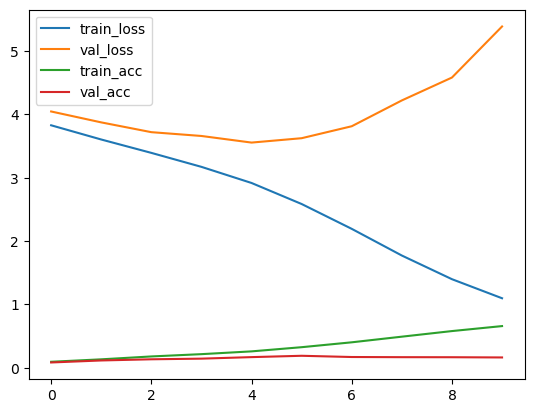

In [58]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Save model

In [ ]:
dump(model, 'Animals_prediction_model.joblib')